# Session II - Bloqade tutorial

On the previous notebook, you have learned the basic functionality and programming commands for Bloqade. Now we are going to tie everything together by running full simulations in some key settings that illustrate how the physics of neutral atoms can be used for solving problems.

*disclaimer: note that Julia is slow the first time it runs a problem, due to pre-compilation. It will run fast after a first run through a calculation.*

### Preparations

To get started let's include some packages that will be useful.

In [1]:
using Bloqade
using Random
Random.seed!(42)
using PythonCall
plt = pyimport("matplotlib.pyplot");

┌ Warning: Error requiring `Juno` from `Measurements`
│   exception = (LoadError("/Users/Plopes/.julia/packages/Measurements/hcRfF/ext/MeasurementsJunoExt.jl", 19, UndefVarError(:measure)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x000000010181278f, Ptr{Nothing} @0x0000000101842673, Ptr{Nothing} @0x0000000101842e5b, Ptr{Nothing} @0x000000010184165f, Ptr{Nothing} @0x0000000101841caf, Base.InterpreterIP in top-level CodeInfo for Measurements.MeasurementsJunoExt at statement 1, Ptr{Nothing} @0x000000010185ddef, Ptr{Nothing} @0x000000010185d663, Ptr{Nothing} @0x000000010185dc43, Ptr{Nothing} @0x000000010185e9d7, Ptr{Nothing} @0x0000000118320883, Ptr{Nothing} @0x0000000101828893, Ptr{Nothing} @0x000000017f55437f, Ptr{Nothing} @0x000000017f71c033, Ptr{Nothing} @0x000000017f71c04b, Ptr{Nothing} @0x0000000101828893, Ptr{Nothing} @0x0000000101835973, Ptr{Nothing} @0x000000029e44c037, Ptr{Nothing} @0x000000029e44c04f, Ptr{Nothing} @0x0000000101828893, Ptr{Nothing} @0x0000000101842e

# I. Quantum Dynamics

Let's start by looking at the dynamics of a single qubit in the presence of a Rabi term.

We start by creating a register of a single atom,

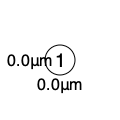

In [2]:
atom1 = AtomList([(0.0, 0.0)])

and a Hamiltonian with a Rabi drive $\Omega=2$ MHz

In [24]:
Δ = 0
Ω = 2π * 2

h1 = rydberg_h(atom1; Δ = 0, Ω = 2π * 2)

nqubits: 1
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] 2π ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 0.0 ⋅ ∑ n_i


Now let's finish the steps to run a quantum job. We start by initializing our register; here we pick the $|\psi(0)\rangle=|0\rangle$ state to set boundary conditions

In [25]:
reg1 = zero_state(1)

ArrayReg{2, ComplexF64, Array...}
    active qubits: 1/1
    nlevel: 2

Now let's consider the actual time evolution. Since we are interested in dynamics here, we have to work a little. We pick a total time of $1.5 \mu s$, discretize time in tiny pieces $\delta t=10^{-2}$ for numerical evolution, and pick a method to solve the time evolution (here we are using `KrylovEvolution`)

In [26]:
total_time = 1.5
clocks = 0.0:1e-2:total_time
prob1 = KrylovEvolution(reg1, clocks, h1)

density1 = zeros(1, length(clocks));

for info in prob1
    density1[1, info.step] = rydberg_density(info.reg, 1)
end

Finally, let's measure something! Here, we plot the evolution of the mean value of the Rydberg number. We see, as expected $n(t)=\cos^2 (\Omega t)$

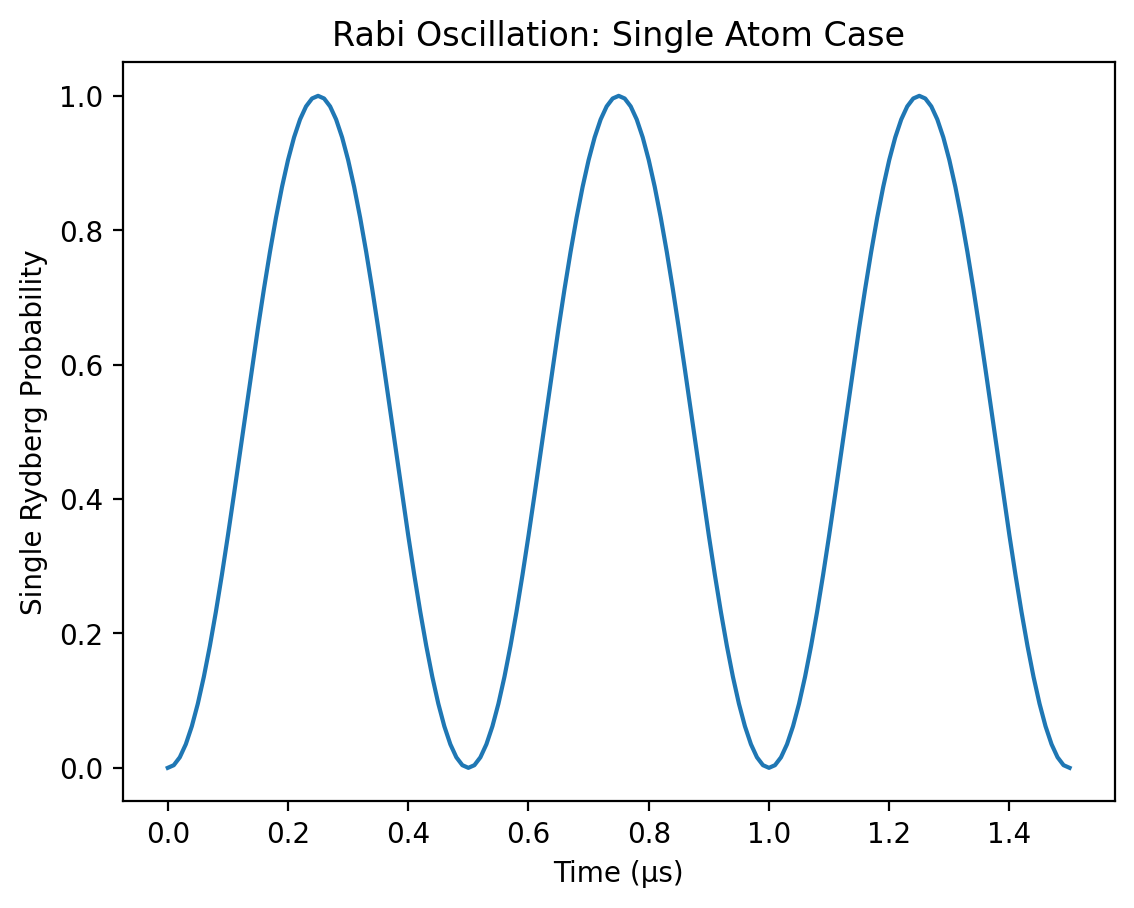

In [27]:
fig, ax = plt.subplots()
ax.plot(clocks, density1[1, :])
ax.set_xlabel("Time (μs)")
ax.set_ylabel("Single Rydberg Probability")
ax.set_title("Rabi Oscillation: Single Atom Case")
fig

## Exercise:

Let's do this again for 2 atoms. Below we have a simple approach to it.

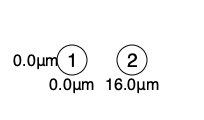

In [31]:
separation=16.0
atom2 = generate_sites(ChainLattice(), 2, scale = separation)

In [32]:
h2 = rydberg_h(atom2; Δ = 0, Ω = 2π * 2)

reg2 = zero_state(2)

total_time = 1.5
clocks = 0.0:1e-2:total_time
prob2 = KrylovEvolution(reg2, clocks, h2)
density2 = zeros(2, length(clocks));

for info in prob2
    for i in 1:2
        density2[i, info.step] = rydberg_density(info.reg, i)
    end
end
density2 = sum(density2, dims = 1);


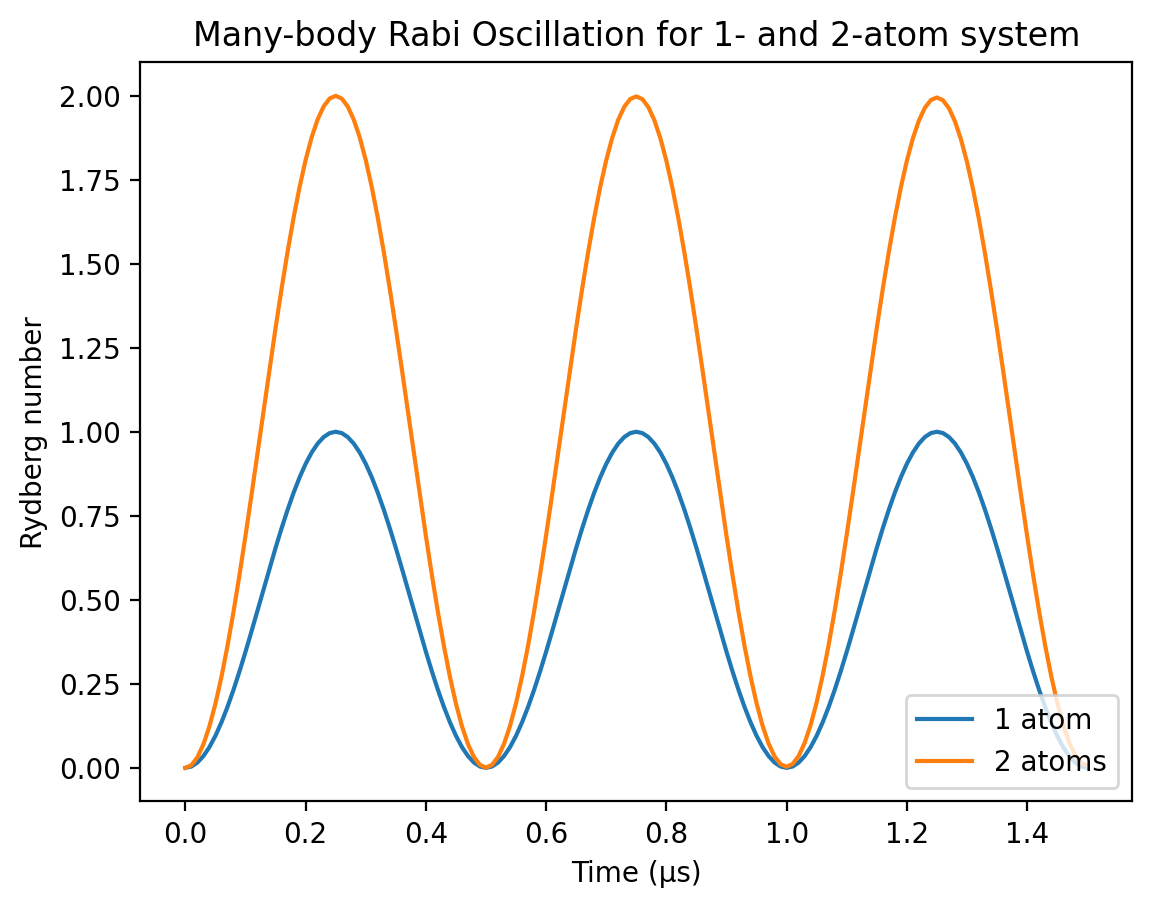

In [33]:
fig, ax = plt.subplots()
ax.plot(clocks, density1[1, :])
ax.plot(clocks, density2[1, :])
ax.set_xlabel("Time (μs)")
ax.set_ylabel("Rydberg number")
ax.set_title("Many-body Rabi Oscillation for 1- and 2-atom system")
ax.legend(["1 atom", "2 atoms"], loc = "lower right")
fig

Now the main exercise. Run the calculation for different values of the qubit separation. What do you observe in the Rabi frequency? What do you think is going on? Which states form the time-dependent state manifold?

# II. Application Examples

## Checkerboards!

Following the lecture discussion, let's try to prepare a checkerboard state

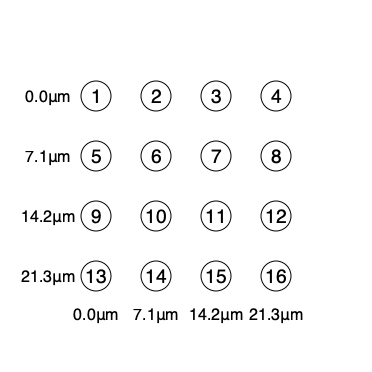

In [34]:
a=7.1

atoms = generate_sites(SquareLattice(), 4,4; scale = a)

pick a blockade radius according to first-neighbor 

In [11]:
Rb=sqrt(sqrt(2))*a

#Rb=sqrt(2*sqrt(5))*a

8.44337051651932

which means

In [12]:
Rb/a

1.189207115002721

Well into the good height in the y-axis of the phase diagram on slide 11 of Session II's slides.

Let's check if we are defining things properly looking at the lattice:

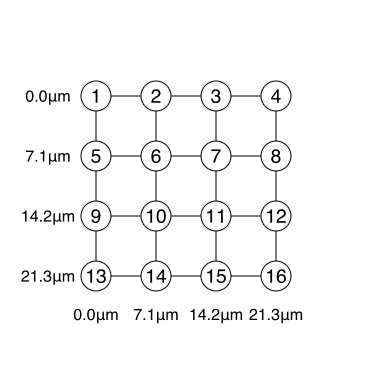

In [13]:
Bloqade.plot(atoms, blockade_radius = Rb)

Sounds like we are doing well!

Now the actual inter-atomic distance affects the energy scales at play, and our $\Omega_{max}=2\pi*2.5=15.7$ Mhz. So we better check that we can get a Rabi frequency on the hardware that matches this blockade radius:

In [14]:
C6 = 2π * 862690;
Ω_max= C6 / Rb^6

14.960273953348786

We seem to be all good! Fixing the x-axis amounts to then picking a good detuning which we will fix at $\Delta/\Omega=2.5$. Then, Let's create the algorithm

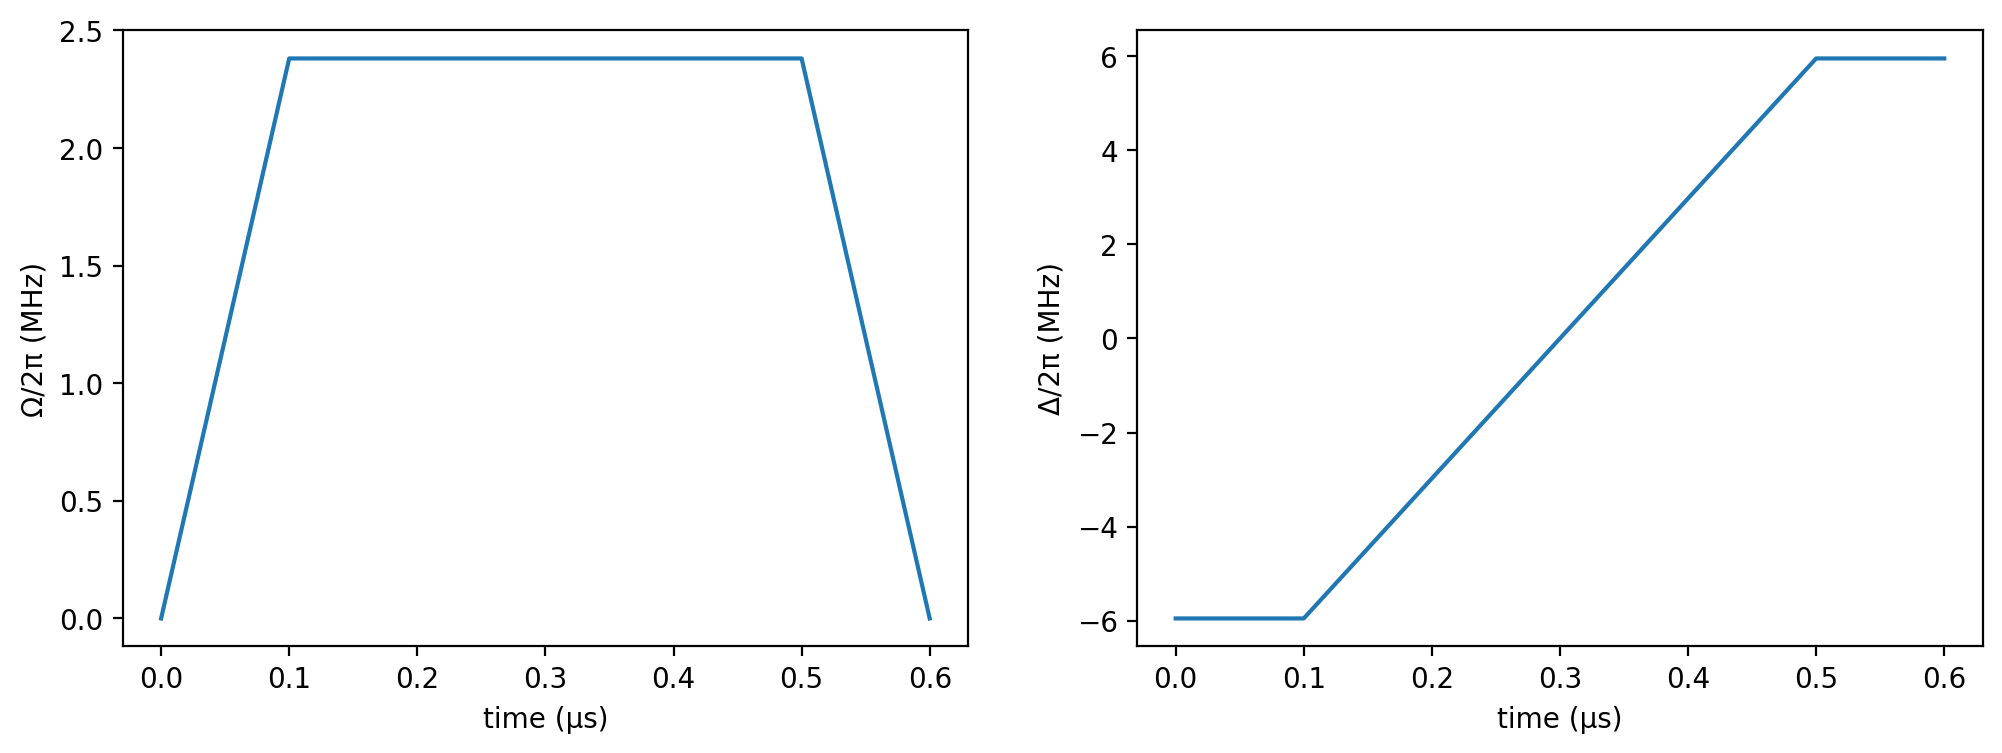

In [15]:
#Total evolution time
T_max = 0.6

Δ_max = 2.5*Ω_max

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.5, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])
ϕ = piecewise_constant(clocks=[0.0,T_max], values= [0.0]); #this is not necessary. Here for later use

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

Now run!

In [16]:
h = rydberg_h(atoms; Ω = Ω, Δ = Δ, ϕ = ϕ)
prob = SchrodingerProblem(zero_state(nqubits(h)), T_max, h);

emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.6)

  equation: 
    storage size: 25.000 MiB
    expression:
nqubits: 16
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅∑ e^{ϕ(t) ⋅ im} |0⟩⟨1| + e^{-ϕ(t) ⋅ im} |1⟩⟨0|
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10


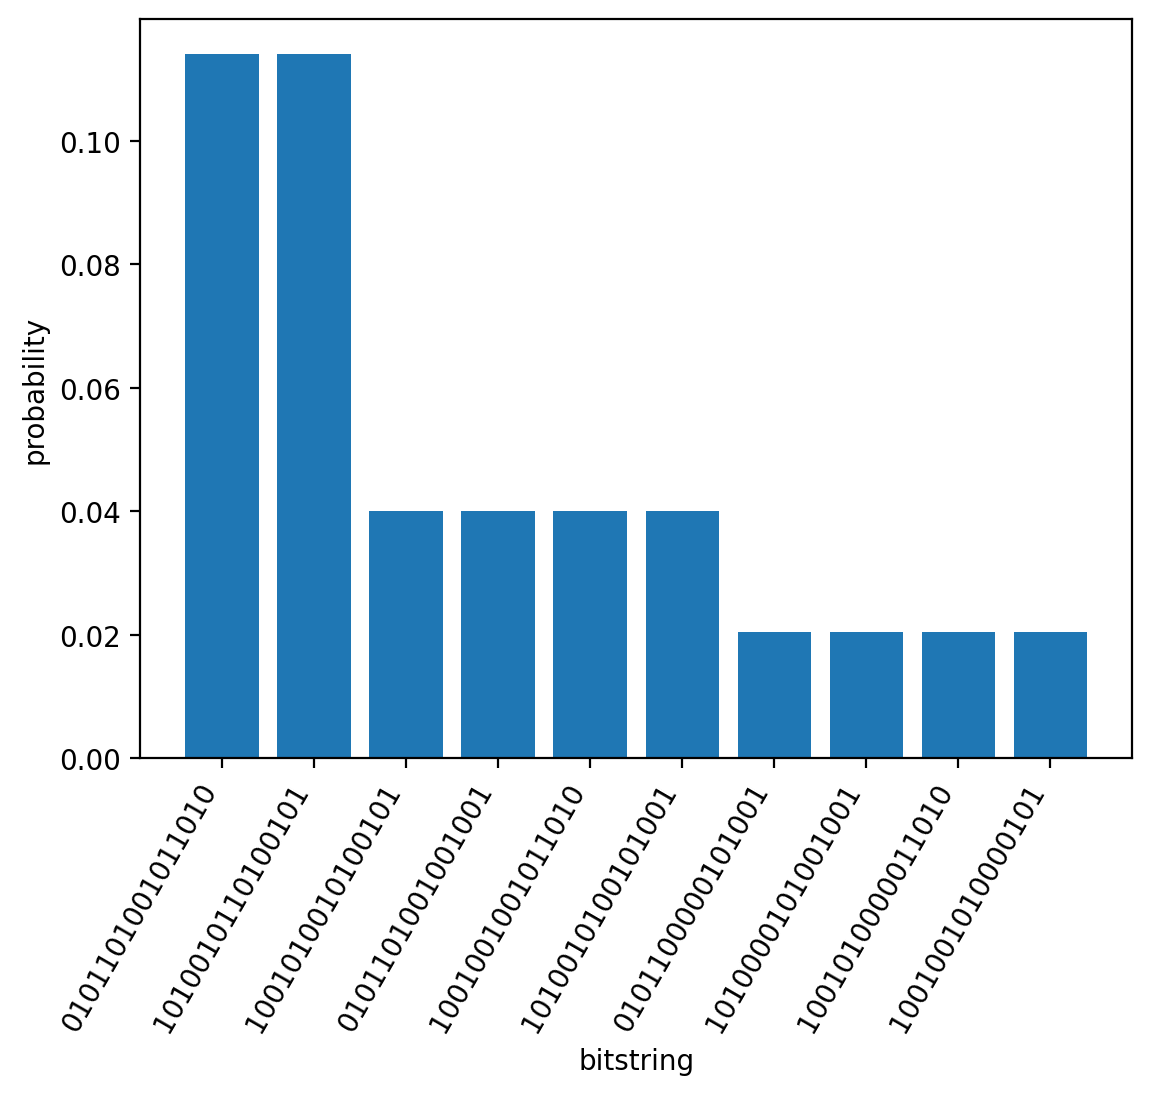

In [17]:
bitstring_hist(prob.reg; nlargest = 10)

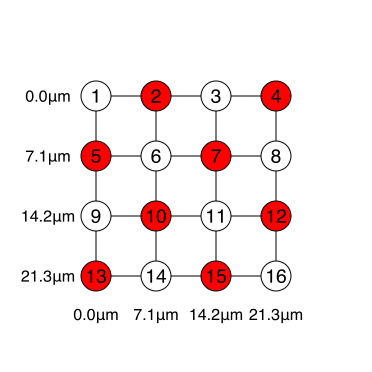

In [18]:
best_bit_strings = most_probable(prob.reg, 4)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])


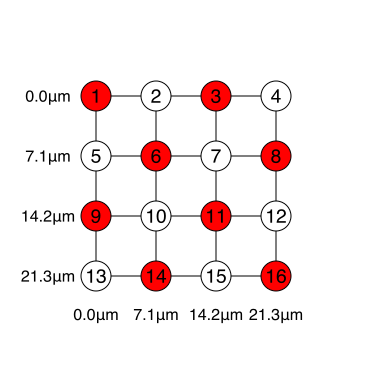

In [19]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

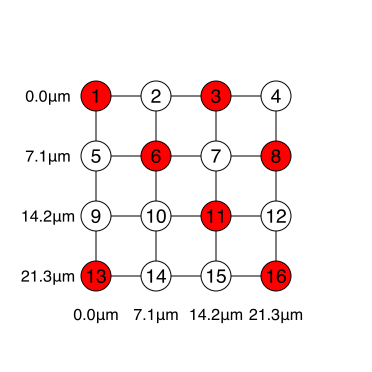

In [20]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[3]])


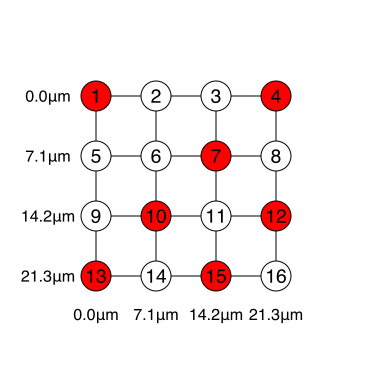

In [21]:
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[4]])

### Exercise

Rerun the code above for other phases on the square lattice

# Conclusion

This is a wrap! Congratulations, you are a Bloqade initiate and from now on we can move to advanced topics!